In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

## Import and visualize data

In [2]:
# process outflow data
outflow_data = pd.read_csv('4200 Modified Average Daily Streamflows.csv')
outflow_data.rename(columns={'Ice Harbor Daily Streamflows (unit:cfs)': 'Ice Harbor outflow (cfs)'}, inplace=True)
outflow_data.rename(columns={'Lower Monumental (unit:cfs)': 'Lower Monumental outflow (cfs)'}, inplace=True)
outflow_data.rename(columns={'Little Goose (unit:cfs)': 'Little Goose outflow (cfs)'}, inplace=True)
outflow_data.rename(columns={'Lower Granite (unit:cfs)': 'Lower Granite outflow (cfs)'}, inplace=True)
outflow_data['date'] = pd.to_datetime(outflow_data['date'])
outflow_data.rename(columns={'date':'datetime'}, inplace=True)

# process precipitation data for runoff calculations
precip_data = pd.read_csv('NOAAprecipitation_data_LEWISTON_AIRPORT_ID.csv')
precip_data = precip_data.drop(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION', 'SNWD', 'SNOW'], axis=1)
precip_data.rename(columns={'PRCP':'rainfall (in)', 'DATE':'datetime'}, inplace=True)
precip_data['datetime'] = pd.to_datetime(precip_data['datetime'], format='%Y-%m-%d')

# process Clearwater River flow
upstream_flow = pd.read_csv('nwis.waterdata.usgsclearwater.txt', sep='\t', header=27)
upstream_flow = upstream_flow.drop(0)
upstream_flow['datetime'] = pd.to_datetime(upstream_flow['datetime'], format='%Y-%m-%d %H:%M').dt.date
upstream_flow = upstream_flow.drop(['agency_cd', 'site_no', 'tz_cd', '191671_00060_cd'], axis=1)
upstream_flow.rename(columns={'191671_00060':'upstream flow (cfs)'}, inplace=True)
upstream_flow['upstream flow (cfs)'] = pd.to_numeric(upstream_flow['upstream flow (cfs)'], errors='coerce')
upstream_flow = upstream_flow.groupby('datetime')['upstream flow (cfs)'].mean().reset_index()
upstream_flow['datetime'] = pd.to_datetime(upstream_flow['datetime'])

# process Snake river flow
snake_flow = pd.read_csv('snakeriverAnatoneUSGSflow.txt', sep='\t', header=28)
snake_flow = snake_flow.drop(0)
snake_flow['datetime'] = pd.to_datetime(upstream_flow['datetime'], format='%Y-%m-%d %H:%M').dt.date
snake_flow = snake_flow.drop(['agency_cd', 'site_no', 'tz_cd', '151907_00060_cd'], axis=1)
snake_flow.rename(columns={'151907_00060':'Snake flow (cfs)'}, inplace=True)
snake_flow['Snake flow (cfs)'] = pd.to_numeric(snake_flow['Snake flow (cfs)'], errors='coerce')
snake_flow = snake_flow.groupby('datetime')['Snake flow (cfs)'].mean().reset_index()
snake_flow['datetime'] = pd.to_datetime(snake_flow['datetime'])

# merge the dataframes
flow_data = outflow_data.merge(upstream_flow, how='inner', on=['datetime'])
input_data = flow_data.merge(precip_data, how='inner', on=['datetime'])
input_data = input_data.merge(snake_flow, how='inner', on=['datetime'])
input_data['upstream flow (cfs)'] = input_data['upstream flow (cfs)'] + input_data['Snake flow (cfs)']
input_data = input_data.drop(columns='Snake flow (cfs)')

input_data = input_data[input_data['datetime'] > datetime(1995,1,1)]

display(input_data)

/var/folders/g8/67bmljw57jq202ggfmzpdkvm0000gn/T/ipykernel_53737/1455461245.py:17: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  upstream_flow = pd.read_csv('nwis.waterdata.usgsclearwater.txt', sep='\t', header=27)
/var/folders/g8/67bmljw57jq202ggfmzpdkvm0000gn/T/ipykernel_53737/1455461245.py:27: DtypeWarning: Columns (1,4) have mixed types. Specify dtype option on import or set low_memory=False.
  snake_flow = pd.read_csv('snakeriverAnatoneUSGSflow.txt', sep='\t', header=28)


,datetime,Ice Harbor outflow (cfs),Lower Monumental outflow (cfs),Little Goose outflow (cfs),Lower Granite outflow (cfs),upstream flow (cfs),rainfall (in)
1543,1995-01-02,21588,21840,20664,20171,25758.958333,0.00
1544,1995-01-03,18241,18326,17304,17089,25305.937500,0.00
1545,1995-01-04,18355,18226,17294,17289,25167.812500,0.00
1546,1995-01-05,18512,18348,17432,17595,25255.833333,0.00
1547,1995-01-06,18792,19001,18121,18514,25436.458333,0.01
...,...,...,...,...,...,...,...
10175,2018-09-26,17428,18068,17945,17918,12562.083333,0.00
10176,2018-09-27,17526,18607,18484,18519,12548.105263,0.00
10177,2018-09-28,17245,18291,18170,18192,12532.187500,0.00
10178,2018-09-29,17863,18637,18515,18493,12505.416667,0.00


### Visualize one year

Text(0, 0.5, 'Outflow data from each dam (cfs)')

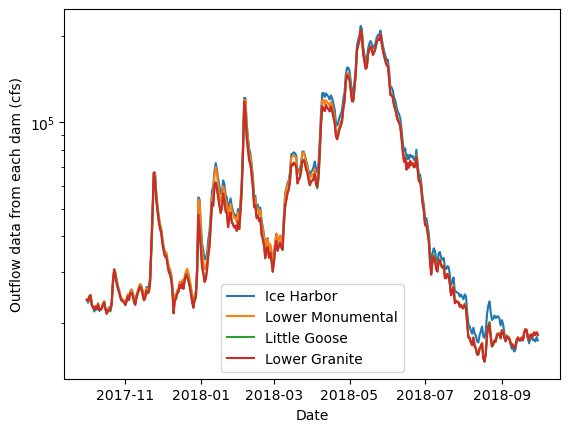

In [60]:
sns.lineplot(x='datetime', y='Ice Harbor outflow (cfs)', data=outflow_data[-365:], label='Ice Harbor')
sns.lineplot(x='datetime', y='Lower Monumental outflow (cfs)', data=outflow_data[-365:], label='Lower Monumental')
sns.lineplot(x='datetime', y='Little Goose outflow (cfs)', data=outflow_data[-365:], label='Little Goose')
sns.lineplot(x='datetime', y='Lower Granite outflow (cfs)', data=outflow_data[-365:], label='Lower Granite')

plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Outflow data from each dam (cfs)')

Text(0, 0.5, 'Streamflow (cfs)')

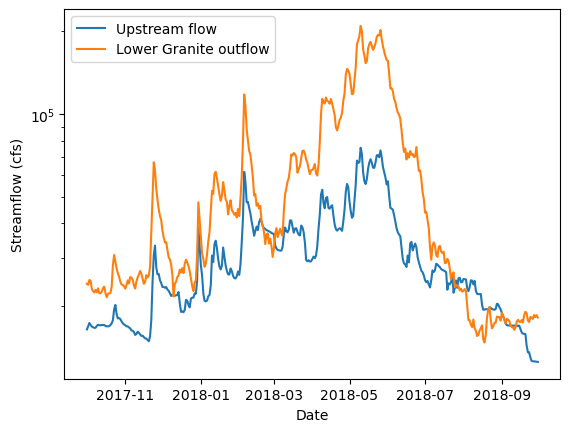

In [11]:
sns.lineplot(x='datetime', y='upstream flow (cfs)', data=input_data[-365:], label='Upstream flow')
sns.lineplot(x='datetime', y='Lower Granite outflow (cfs)', data=input_data[-365:], label='Lower Granite outflow')

plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Streamflow (cfs)')

Text(0.5, 1.0, 'Regional precipitation')

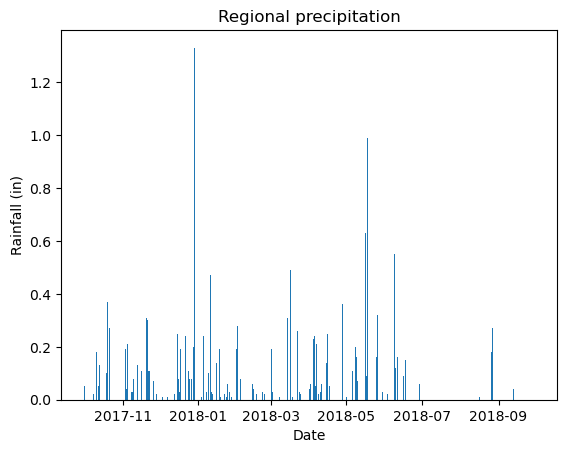

In [20]:
plt.bar(x=input_data['datetime'][-365:], height=input_data['rainfall (in)'][-365:])

plt.xlabel('Date')
plt.ylabel('Rainfall (in)')
plt.title('Regional precipitation')

### Visualize entire dataset

Text(0, 0.5, 'Outflow data from each dam (cfs)')

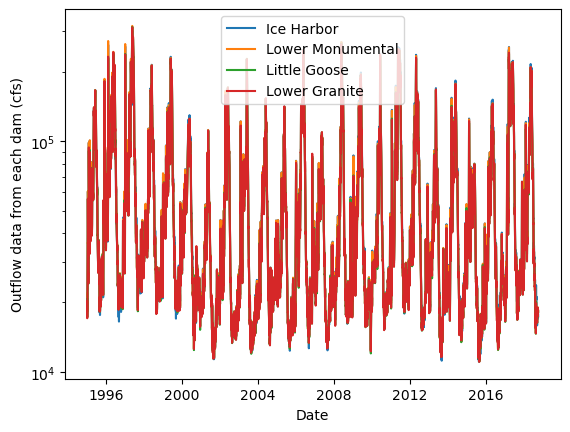

In [25]:
sns.lineplot(x='datetime', y='Ice Harbor outflow (cfs)', data=input_data, label='Ice Harbor')
sns.lineplot(x='datetime', y='Lower Monumental outflow (cfs)', data=input_data, label='Lower Monumental')
sns.lineplot(x='datetime', y='Little Goose outflow (cfs)', data=input_data, label='Little Goose')
sns.lineplot(x='datetime', y='Lower Granite outflow (cfs)', data=input_data, label='Lower Granite')

plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Outflow data from each dam (cfs)')

Text(0, 0.5, 'Streamflow (cfs)')

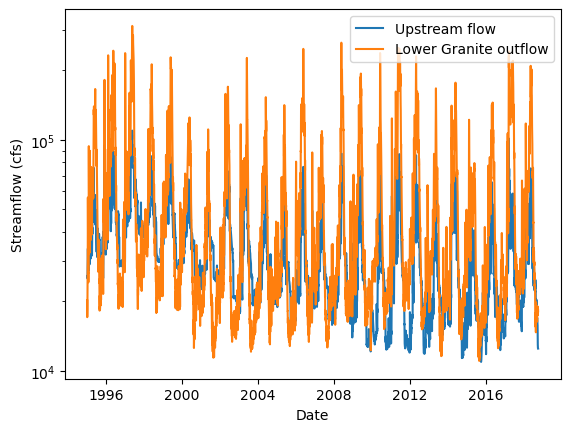

In [26]:
sns.lineplot(x='datetime', y='upstream flow (cfs)', data=input_data, label='Upstream flow')
sns.lineplot(x='datetime', y='Lower Granite outflow (cfs)', data=input_data, label='Lower Granite outflow')

plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Streamflow (cfs)')

Text(0.5, 1.0, 'Regional precipitation')

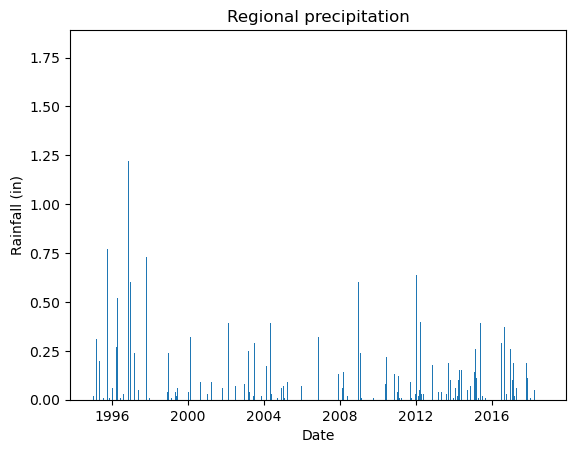

In [27]:
plt.bar(x=input_data['datetime'], height=input_data['rainfall (in)'])

plt.xlabel('Date')
plt.ylabel('Rainfall (in)')
plt.title('Regional precipitation')

## Initialize reservoirs

In [3]:
from Reservoir import Reservoir

ice_harbor = Reservoir(SA=9200*4047,num_turb=6,capacity=603000,tail_elev=339,pool_elev=446,bottom_elev=310,fish_pass=0.965, area=550_000_000)
lower_monumental = Reservoir(SA=6590*4047,num_turb=6,capacity=810000,tail_elev=439,pool_elev=548.3,bottom_elev=406,fish_pass=0.965, area=1_610_000_000)
little_goose = Reservoir(SA=10025*4047,num_turb=6,capacity=903000,tail_elev=539,pool_elev=646.5,bottom_elev=500,fish_pass=0.9775, area=1_175_000_000)
lower_granite = Reservoir(SA=8900*4047,num_turb=6,capacity=810000,tail_elev=636,pool_elev=746.5,bottom_elev=590,fish_pass=1, area=2_477_000_000)

## Simulate reservoirs

In [4]:
input_data['Lower Granite inflow (cfs)'] = lower_granite.simulate_inflow(input_data['rainfall (in)'].values, input_data['upstream flow (cfs)'].values)
input_data['Lower granite storage (m^3)'] = lower_granite.simulate_storage(1_000_000_000, 1, input_data['upstream flow (cfs)'].values*86400*0.0283, input_data['Lower Granite outflow (cfs)'].values*86400*0.0283)

display(input_data)

,datetime,Ice Harbor outflow (cfs),Lower Monumental outflow (cfs),Little Goose outflow (cfs),Lower Granite outflow (cfs),upstream flow (cfs),rainfall (in),Lower Granite inflow (cfs),Lower granite storage (m^3)
1543,1995-01-02,21588,21840,20664,20171,25758.958333,0.00,NaN,1.000000e+09
1544,1995-01-03,18241,18326,17304,17089,25305.937500,0.00,NaN,1.020091e+09
1545,1995-01-04,18355,18226,17294,17289,25167.812500,0.00,NaN,1.039356e+09
1546,1995-01-05,18512,18348,17432,17595,25255.833333,0.00,NaN,1.058088e+09
1547,1995-01-06,18792,19001,18121,18514,25436.458333,0.01,NaN,1.075014e+09
...,...,...,...,...,...,...,...,...,...
10175,2018-09-26,17428,18068,17945,17918,12562.083333,0.00,NaN,2.022563e+08
10176,2018-09-27,17526,18607,18484,18519,12548.105263,0.00,NaN,1.876567e+08
10177,2018-09-28,17245,18291,18170,18192,12532.187500,0.00,NaN,1.738178e+08
10178,2018-09-29,17863,18637,18515,18493,12505.416667,0.00,NaN,1.591774e+08


Text(0, 0.5, 'Reservoir storage (cfs)')

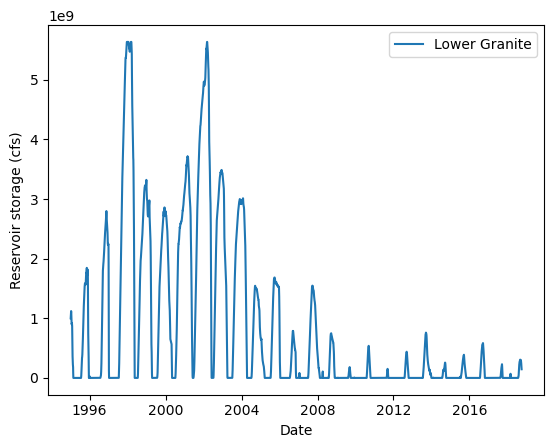

In [8]:
# sns.lineplot(x='datetime', y='Ice Harbor outflow (cfs)', data=input_data, label='Ice Harbor')
# sns.lineplot(x='datetime', y='Lower Monumental outflow (cfs)', data=input_data, label='Lower Monumental')
# sns.lineplot(x='datetime', y='Little Goose outflow (cfs)', data=input_data, label='Little Goose')
sns.lineplot(x='datetime', y='Lower granite storage (m^3)', data=input_data, label='Lower Granite')

#plt.yscale('log')
plt.xlabel('Date')
plt.ylabel('Reservoir storage (cfs)')

## OLD: Simulate reservoirs

In [83]:
x = 0
res_info = pd.DataFrame({'Names':['Ice Harbor','Lower Monumental','Little Goose','Lower Granite'],
                         'Reservoir surface area (m^2)':[9200*4047,6590*4047,10025*4047,8900*4047],
                         'Number of turbines':[6,6,6,6],
                         'Generation capacity (kW)':[603000,810000,903000,810000],
                         'Average tailwater elevation (m)':[339,439,539,636],
                         'Maximum pooling elevation (m)':[446.0,548.3,646.5,746.5],
                         'Fish Passage Rate (%)':[.965,.965,.9775,x],
                         'Watershed Area (acres)':[103_352,95_277,83_074,111_602]
                         })
res_info['Generation capacity (kW)'] = pd.to_numeric(res_info['Generation capacity (kW)'])
display(res_info)

eta = 0.8 # efficiency of turbines, assumed value
rho = 998 # density of water, 1000 kg/m^3
g = 9.81 # gravitational acceleration, 9.81 m/s^2

# generate inflow from previous reservoir outflow/gage data, and added runoff data
# PLACEHOLDER
def simulate_inflow(data):
    return data*1.1

# simulate reservoir
def simulate_reservoir(df, initial_storage, keep, resID):
    # df is a dataframe containing reservoir data. Has columns 'inflow (cfs)'
    #       and 'outflow (cfs)'. Timestep is in days.
    # keep is a boolean. Keep = 0, remove = 1
    # resID is the string name of the reservoir
    # this function will directly modify a DataFrame!
    info = res_info[res_info['Names'] == resID].iloc[0]
    df['storage (cf)'] = 3000000
    max_storage = info['Maximum pooling elevation (m)']*info['Reservoir surface area (m^2)']
    df.loc[0,'storage (cf)'] = initial_storage
    if keep == 0:
        df['storage (cf)'] = df['storage (cf)'].cumsum() + (df['inflow (cfs)'] - df['outflow (cfs)'])*86400
        df['storage (m^3)'] = np.minimum(df['storage (cf)']/35.315,max_storage)
        df['elevation head (m)'] = df['storage (m^3)']/info['Reservoir surface area (m^2)']
        df['power produced (kWh)'] = np.minimum(eta*rho*g*df['elevation head (m)']*df['storage (cf)']*info['Number of turbines'], info['Generation capacity (kW)'])
    else:
        df['storage (cf)'] = 0
        df['elevation head (m)'] = 0
        df['power produced (kWh)'] = 0
        df['outflow (cfs)'] = df['inflow (cfs)']

    return None

# simulate the whole system
def simulate_system(df):
    # - df is dataframe with Ice Harbor, Lower Monumental, Little Goose, and Lower Granite
    return None

,Names,Reservoir surface area (m^2),Number of turbines,Generation capacity (kW),Average tailwater elevation (m),Maximum pooling elevation (m),Fish Passage Rate (%),Watershed Area (acres)
0,Ice Harbor,37232400,6,603000,339,446.0,0.9650,103352
1,Lower Monumental,26669730,6,810000,439,548.3,0.9650,95277
2,Little Goose,40571175,6,903000,539,646.5,0.9775,83074
3,Lower Granite,36018300,6,810000,636,746.5,0.0000,111602


In [84]:
# simulate Lower Granite reservoir
lower_granite = pd.DataFrame(outflow_data['Lower Granite outflow (cfs)'])
lower_granite['inflow (cfs)'] = input_data['upstream flow (cfs)']
lower_granite.rename(columns={'Lower Granite outflow (cfs)':'outflow (cfs)'}, inplace=True)
display(lower_granite)
simulate_reservoir(lower_granite,100000,0,'Lower Granite')
display(lower_granite)

,outflow (cfs),inflow (cfs)
0,56639,24492.886598
1,49861,24443.195876
2,46219,24429.072165
3,45121,24405.979381
4,41992,24402.474227
...,...,...
32959,17918,NaN
32960,18519,NaN
32961,18192,NaN
32962,18493,NaN


,outflow (cfs),inflow (cfs),storage (cf),storage (m^3),elevation head (m),power produced (kWh)
0,56639,24492.886598,-2.777324e+09,-7.864432e+07,-2.183455,810000.0
1,49861,24443.195876,-2.192998e+09,-6.209821e+07,-1.724074,810000.0
2,46219,24429.072165,-1.876550e+09,-5.313747e+07,-1.475291,810000.0
3,45121,24405.979381,-1.780678e+09,-5.042270e+07,-1.399919,810000.0
4,41992,24402.474227,-1.507635e+09,-4.269107e+07,-1.185260,810000.0
...,...,...,...,...,...,...
32959,17918,NaN,NaN,NaN,NaN,NaN
32960,18519,NaN,NaN,NaN,NaN,NaN
32961,18192,NaN,NaN,NaN,NaN,NaN
32962,18493,NaN,NaN,NaN,NaN,NaN
